## GNN-based FEA Surrogate Model
Experimenting with basic GNN architectures from the repaired dataset leveraging
[PyTorch Geometric](https://github.com/pyg-team/pytorch_geometric)

Using full dataset with batching.

Currently: GCN

In [26]:
# Imports
import os
import torch
from torch_geometric.data import Dataset
import glob
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt

Prevent Memory Issues via Lazy Loading

In [27]:
# Custom Class for Loading Graphs from Disk
class ProcessedGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(ProcessedGraphDataset, self).__init__(root, transform, pre_transform)
        self.processed_files = glob.glob(os.path.join(root, '*.pt'))
        
        if len(self.processed_files) > 0:
            # Load sample graph for props
            sample_graph = torch.load(self.processed_files[0])
            self._num_node_features = sample_graph.num_node_features
            self._num_classes = 1  # Assuming regression
        else:
            raise ValueError("No processed graph files found.")
    
    @property
    def num_node_features(self):
        return self._num_node_features
    
    @property
    def num_classes(self):
        return self._num_classes
    
    def len(self):
        return len(self.processed_files)
    
    def get(self, idx):
        graph = torch.load(self.processed_files[idx])
        return graph

In [28]:
from torch.utils.data import random_split

# Initialize the dataset
dataset = ProcessedGraphDataset(root='../../data/processed/processed_graphs')

# Split
train_length = int(len(dataset) * 0.8)
test_length = len(dataset) - train_length

train_dataset, test_dataset = random_split(dataset, [train_length, test_length])

#### Test with Unoptimized Model

In [29]:
# Same Model (GCNConv)
class QualityPredictor(torch.nn.Module):
    def __init__(self, num_node_features):
        super(QualityPredictor, self).__init__()
        # Define layers
        self.conv1 = GCNConv(in_channels=num_node_features, out_channels=64)
        self.conv2 = GCNConv(in_channels=64, out_channels=32)
        self.conv3 = GCNConv(in_channels=32, out_channels=16)  # Third GCN layer
        self.fc = torch.nn.Linear(in_features=16, out_features=1)  # Update input to match last GCN output size
        self.dropout = torch.nn.Dropout(p=0.5)  # Added dropout for regularization

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply GCN layers with ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))  # Added third layer

        # Apply dropout (after last GCN layer)
        x = self.dropout(x)
        
        # Global mean pooling to get graph-level embeddings
        x = global_mean_pool(x, batch)
        
        # Final fully connected layer
        x = self.fc(x)
        
        # Output is a single value per graph
        return x.view(-1)

Adjust batch size and worker count depending on memory constraints.

In [ ]:
# Initialize the dataset
dataset = ProcessedGraphDataset(root='../../data/processed/processed_graphs')
print(f"Dataset size: {len(dataset)}")

# Split the dataset
train_length = int(len(dataset) * 0.8)
test_length = len(dataset) - train_length
train_dataset, test_dataset = random_split(dataset, [train_length, test_length])

# Create DataLoaders
batch_size = 64
num_workers = 0 # TODO: Confirm value 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Dataset size: 482213


In [31]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QualityPredictor(num_node_features=dataset.num_node_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Switch to L1 loss
criterion = torch.nn.L1Loss()
num_epochs = 25

In [32]:
# Learning Rate Scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Variables for early stopping
best_val_loss = float('inf')
patience_counter = 0
max_patience = 3

# Store loss values
training_losses = []
validation_losses = []
validation_rmse = []

#### Sample Training Loop

Time: 472m 36.9s w/ LR = 0.001 and batch size = 4 for 10 epochs
Time: 873m 24.2 w/ LR = 0.001 and batch size = 64 for 10 epochs

In [33]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * batch.num_graphs
        del batch
        torch.cuda.empty_cache()
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    training_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    squared_errors = []  # For RMSE
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            val_loss = criterion(out, batch.y.view(-1))
            total_val_loss += val_loss.item() * batch.num_graphs
            squared_errors.extend((out.cpu().numpy() - batch.y.cpu().numpy()) ** 2)
            del batch
            torch.cuda.empty_cache()
    avg_val_loss = total_val_loss / len(test_loader.dataset)
    validation_losses.append(avg_val_loss)
    
    # Compute RMSE
    rmse = (sum(squared_errors) / len(test_loader.dataset)) ** 0.5
    validation_rmse.append(rmse)
    
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, RMSE: {rmse:.4f}')
    
    # Step the scheduler
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '../../models/best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print("Early stopping triggered.")
            break

Epoch 1, Training Loss: 3.2577, Validation Loss: 3.2129, RMSE: 16.8816
Epoch 2, Training Loss: 3.1766, Validation Loss: 3.2037, RMSE: 16.9075
Epoch 3, Training Loss: 3.1711, Validation Loss: 3.1989, RMSE: 16.8941
Epoch 4, Training Loss: 3.1677, Validation Loss: 3.1979, RMSE: 16.8895
Epoch 5, Training Loss: 3.1642, Validation Loss: 3.1901, RMSE: 16.8879
Epoch 6, Training Loss: 3.1609, Validation Loss: 3.1868, RMSE: 16.8830
Epoch 7, Training Loss: 3.1581, Validation Loss: 3.1850, RMSE: 16.8856
Epoch 8, Training Loss: 3.1563, Validation Loss: 3.1865, RMSE: 16.8819
Epoch 9, Training Loss: 3.1550, Validation Loss: 3.1820, RMSE: 16.8824
Epoch 10, Training Loss: 3.1543, Validation Loss: 3.1785, RMSE: 16.8715


KeyboardInterrupt: 

#### Results

Epoch 1, Training Loss: 3.2134, Validation Loss: 3.1544
Epoch 2, Training Loss: 3.1943, Validation Loss: 3.1501
Epoch 3, Training Loss: 3.1926, Validation Loss: 3.1477
Epoch 4, Training Loss: 3.1911, Validation Loss: 3.1485
Epoch 5, Training Loss: 3.1896, Validation Loss: 3.1479
Epoch 6, Training Loss: 3.1888, Validation Loss: 3.1453
Epoch 7, Training Loss: 3.1880, Validation Loss: 3.1442
Epoch 8, Training Loss: 3.1871, Validation Loss: 3.1458
Epoch 9, Training Loss: 3.1866, Validation Loss: 3.1470
Epoch 10, Training Loss: 3.1860, Validation Loss: 3.1427

2nd run:
Epoch 1, Training Loss: 3.2577, Validation Loss: 3.2129, RMSE: 16.8816
Epoch 2, Training Loss: 3.1766, Validation Loss: 3.2037, RMSE: 16.9075
Epoch 3, Training Loss: 3.1711, Validation Loss: 3.1989, RMSE: 16.8941
Epoch 4, Training Loss: 3.1677, Validation Loss: 3.1979, RMSE: 16.8895
Epoch 5, Training Loss: 3.1642, Validation Loss: 3.1901, RMSE: 16.8879
Epoch 6, Training Loss: 3.1609, Validation Loss: 3.1868, RMSE: 16.8830
Epoch 7, Training Loss: 3.1581, Validation Loss: 3.1850, RMSE: 16.8856
Epoch 8, Training Loss: 3.1563, Validation Loss: 3.1865, RMSE: 16.8819
Epoch 9, Training Loss: 3.1550, Validation Loss: 3.1820, RMSE: 16.8824
Epoch 10, Training Loss: 3.1543, Validation Loss: 3.1785, RMSE: 16.8715

In [31]:
from sklearn.metrics import mean_absolute_error

model.eval()
true_values = []
predicted_values = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data)
        true_values.extend(data.y.cpu().numpy())
        predicted_values.extend(output.cpu().numpy())

mae = mean_absolute_error(true_values, predicted_values)
print(f"Test MAE: {mae:.4f}")

Test MAE: 3.1427


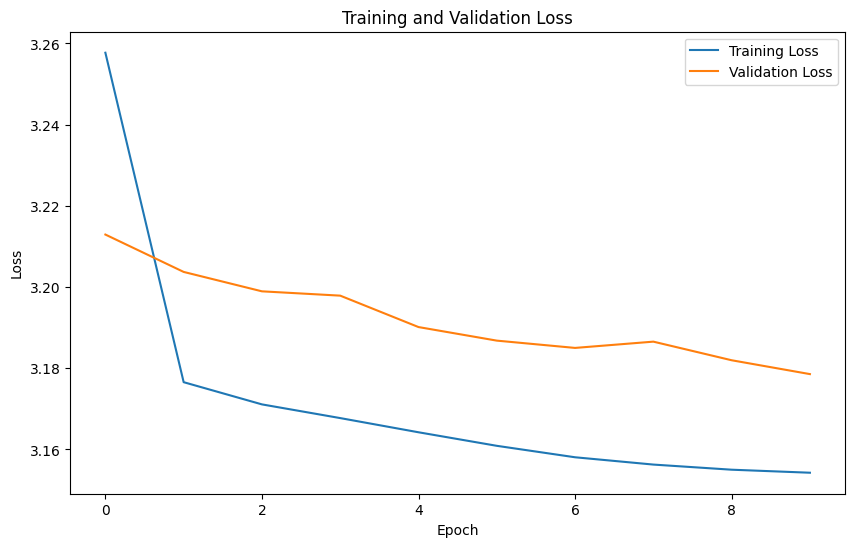

In [34]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

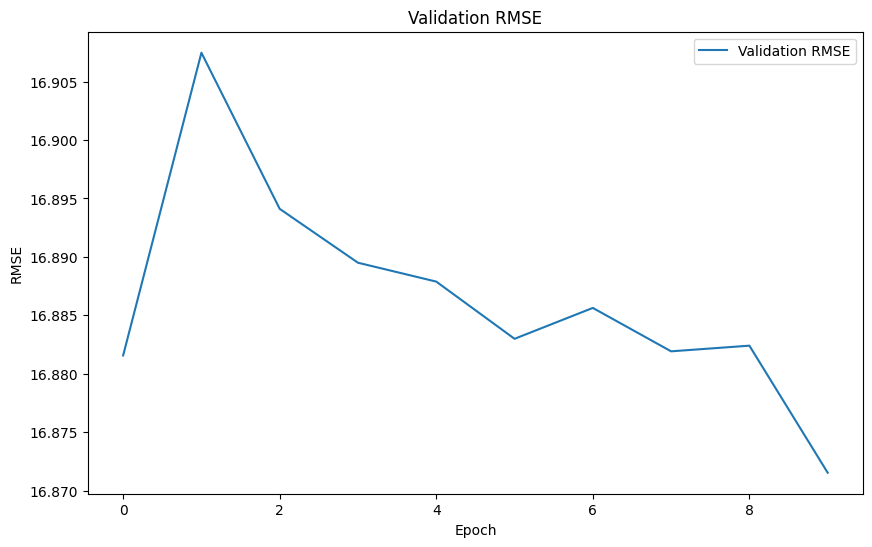

In [35]:
# Plot RMSE
plt.figure(figsize=(10, 6))
plt.plot(validation_rmse, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Validation RMSE')
plt.legend()
plt.show()

#### Save